# Proyecto final 

### Por Carlos Andrés Díaz 

El presente proyecto se basó en el dataset de https://archive.ics.uci.edu/ml/datasets/MAGIC+Gamma+Telescope donado por P. Savicky.
Este muestra la datos simulados de un detector de radiación Cherenkov cuya finalidad es ver si la lluvia electromagnética registrada por sus cámaras es desencadenado por rayos gamma (g) o por lluvia de hadrones de fondo (h) la cual sería la señal ruido. Para esto se analizan los parámetros de la imagen elipsoidal producida, incluyendo su ancho, largo, tamaño, distancia al centro etc. 

Las especificaciones dadas, mencionan que la simple precisión no basta, pues es mucho peor clasificar un evento h como g, que viceversa. Por lo que se prioriza la probabilidad de darse un falso positivo dado por 1-especificidad. Frente a est, se mencionan varias lineas de corte en cuanto a la probabilida máxima: 0.01, 0.02, 0.05, 0.1, 0.2 dependiendo de la calidad esperada. 

El código fue basado en los notebooks y las enseñanzas dadas en el curso: "Curso completo de Machine Learning: Data Science en Python", instruida por Juan Gabriel Gomila Salas, por medio de Udemy Academy 

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import imageio
import chart_studio.tools as tls
from sklearn.preprocessing import StandardScaler


from random import randint
from random import seed

from sklearn.feature_selection import RFE
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn import linear_model

import statsmodels.api as sm

from sklearn.svm import SVC

from sklearn import preprocessing, neighbors

# Importar df de gamma

In [2]:
filepath=("Gamma/magic04.data")
data=pd.read_csv(filepath,sep=",",header=None,names=["Lenght","Width","Size","Conc","Conc1","Asym","fM3Long","fM3Trans","Alpha","Dist","Class"])
data.head()

# Análisis exploratorio

In [3]:
data.tail()

In [4]:
data.shape

In [5]:
data.groupby(["Class"]).count()

Como los primeros 2/3 de los datos son h y el 1/3 del final son h, se requiere desordenar los datos para que los métodos de validación aleatorios sean más efectivos.

In [6]:
rand_seed=0#20
data=data.sample(frac=1,random_state=rand_seed)#20
data.head()

In [7]:
data.corr()

In [8]:
A=pd.get_dummies(data.Class)
data["g"]=A["g"]

In [9]:
X_column_names=data.columns[:-2]

In [10]:
n=5
lr=LogisticRegression()
X_explor_std=StandardScaler().fit_transform(data[X_column_names])
rfe=RFE(lr,n)
rfe=rfe.fit(X_explor_std,data["g"])
list(zip(rfe.ranking_,data.columns.values))

### Analisis exploratorio con regresión simple, usando stats model

In [11]:
logit_model=sm.Logit(data["g"],data[X_column_names])
result=logit_model.fit()
result.summary()

Dado que tanto Azym como fm3Trans muestran un P alto, se eliminarán.
Por el orden de aporte del Componente Conc, se había considerado removerlo sin embargo, al hacerlo se tuvo una ligera desmejora en los reusltados, por lo que se decidió concervarlos.

Dado a la alta multicolinealidad entre los compontentes, se considera usar el método de ACP para obtener un sistema ortogonal y comparar los resultados.


In [12]:
data=data.drop(["Asym","fM3Trans"], axis=1)
data
Col_l=len(data.columns)-2
data.head()

In [13]:
plt.scatter(data.Width,data.Size,c=A["g"],alpha=0.5)

In [14]:
#Imagen producida de plotly
#(0=h, 1=g)
fig = plt.figure(figsize=(21,9))
r_distrib=imageio.imread("Distribucion_ r_elipses.png")
r_distrib.shape
plt.imshow(r_distrib,aspect='auto')

In [15]:
X=data.iloc[:,0:Col_l].values
Y=data.iloc[:,Col_l+1].values

# Método de ACP

## Cálculo de valores propios

Se decidió usar el método manual, ya que el método con sk_pca mostró una ligera desmejoría

In [16]:
x_std=StandardScaler().fit_transform(X)
correlation_matrix=np.corrcoef(X.T)
eig_vals,eig_vects=np.linalg.eig(correlation_matrix)
print(eig_vals)
print(eig_vects)

## Implementación de ACP

In [17]:
eigval_sum=sum(eig_vals)
eigval_sorted=sorted(eig_vals,reverse=True)
eigen_pairs=[(np.abs(eig_vals[i]),eig_vects[:,i]) for i in range(len(eig_vals))]
eigen_pairs.sort(reverse=True)
eigen_pairs

In [18]:
percent_contrib=np.multiply(eigval_sorted,100/eigval_sum)
cum_var=np.cumsum(percent_contrib)
xline_var=list(range(len(cum_var)))
percent_contrib, cum_var

(array([51.94589667, 17.26806416, 11.26886534,  9.273971  ,  5.15647098,
         2.89804375,  1.93565156,  0.25303653]),
 array([ 51.94589667,  69.21396083,  80.48282617,  89.75679718,
         94.91326816,  97.81131191,  99.74696347, 100.        ]))

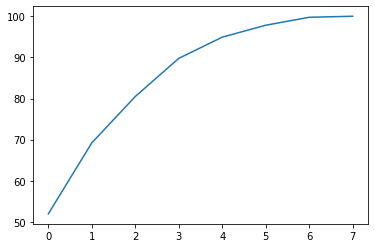

In [19]:
plt.plot(xline_var,cum_var)

<BarContainer object of 8 artists>

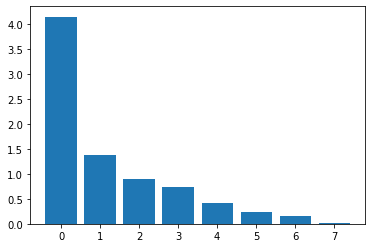

In [20]:
plt.bar(xline_var,eigval_sorted)

Se seleccionan los primeros 5 mayores para explicar el 95% de la varianza

## Creación de matrix W


In [21]:
num_eigval=5
W=[]
for i in range(num_eigval):
    if i==0:
        W=eigen_pairs[i][1].reshape(Col_l,1)
    else:
        W=np.hstack((W,eigen_pairs[i][1].reshape(Col_l,1)))
X_new=x_std.dot(W)
X_new.shape

(19020, 5)

# Entrenamiento de modelos 

Se usará el modelo de regresión logistica, SVM y k nearest y se tratarán de comparar

In [22]:
X_train, X_test, Y_train, Y_test=train_test_split(x_std,Y,test_size=0.3,random_state=rand_seed)
Xeg_train, Xeg_test, Yeg_train, Yeg_test=train_test_split(X_new,Y,test_size=0.3,random_state=rand_seed)
conf_parameter=pd.DataFrame(columns = ['TP','TN','FP','FN'])
Method=[]
Method_count=0
Sensitivities=[]
Especifities=[]

## Funciones para extraer los parámetros de los modelos 

In [23]:
def conf_matrix_parameters(Y_pred,Y_real,show_crs=True):
    conf_matrix=pd.crosstab(Y_pred,Y_real)
    TP=conf_matrix.iloc[1,1]
    TN=conf_matrix.iloc[0,0]
    FN=conf_matrix.iloc[0,1]
    FP=conf_matrix.iloc[1,0]
    if show_crs:
        print(conf_matrix)    
    return [TP,TN,FP,FN] 

In [24]:
def Conf_parameters(TP,TN,FP,FN):
    T_pred=FP+TN+TP+FN
    sens=TP/(TP+FN)
    espec_1=1-TN/(TN+FP)
    prec=TP/(TP+FP)
    acc=(TP+TN)/T_pred
    p_fp=FP/T_pred
    
    return sens, espec_1,prec, acc, p_fp

In [25]:
def ROC_analisis(prob,Y_test,FP_disp=False):
    prob_df=pd.DataFrame(prob)
    threshold=0.1
    prob_df["prediction"]=np.where(prob_df[0]>=threshold, 1,0)
    prob_df["actual"]=list(Y_test)
    prob_df
    threshold=[0.01, 0.05,0.1,0.15,0.20,0.25, 0.3, 0.4,0.5,0.6,0.7,0.75,0.8,0.85,0.9]
    sensitivities=[1]
    especificities_1=[1]
    prob_fp=[1]
    accuracy=[0]
    for t in threshold:
        prob_df["prediction"]=np.where(prob_df[0]>=t, 1,0)
        prob_df["actual"]=list(Y_test)
        prob_df.head()
        [TP,TN,FP,FN]=conf_matrix_parameters(prob_df.prediction,prob_df.actual,show_crs=False)
        T_pred=FP+TN+TP+FN
        sens=TP/(TP+FN)
        sensitivities.append(sens)
        
        espec_1=1-TN/(TN+FP)
        especificities_1.append(espec_1)
        
        p_fp=FP/T_pred
        prob_fp.append(p_fp)
        
    sensitivities.append(0)
    especificities_1.append(0)
    prob_fp.append(0)
    num_sens=len(sensitivities)
    sensitivities_out=np.array(sensitivities).reshape(num_sens,1)
    especificities_1_out=np.array(especificities_1).reshape(num_sens,1)
    if FP_disp:
        prob_fp_out=np.array(prob_fp).reshape(num_sens,1)
        return sensitivities_out,especificities_1_out,prob_fp_out
    
    else:
        return sensitivities_out,especificities_1_out

In [26]:
def Curva_ROC(sens,esp,Method):
    %matplotlib inline
    plt.plot(esp,sens, marker="o", linestyle="--",color="r")
    x=[i*0.01 for i in range(100)]
    y=[i*0.01 for i in range(100)]
    plt.plot(x,y)
    plt.xlabel("1-Especifidad")
    plt.ylabel("Sensibilidad")
    plt.title("Curva ROC " +Method)

# Regresión logística

## Logistica sin ACP 

In [27]:
Method.append("Log")
Method_count=+1

In [28]:
logit_model=linear_model.LogisticRegression()
logit_model.fit(X_train,Y_train)
logit_model.score(X_train,Y_train)

0.7887186420309449

### Validación Cruzada

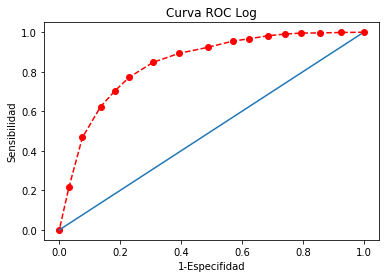

In [29]:
Y_pred=logit_model.predict(X_test)
probs=logit_model.predict_proba(X_test)
Sensitivities_temp, Especifities_temp=ROC_analisis(probs[:,1],Y_test)
Curva_ROC(Sensitivities_temp,Especifities_temp,str(Method[Method_count-1]))
Sensitivities=Sensitivities_temp
Especifities=Especifities_temp

### Matriz de confusión 

In [30]:
tempdf=pd.DataFrame([conf_matrix_parameters(Y_pred,Y_test)],columns = ['TP','TN','FP','FN'])
conf_parameter = pd.concat([conf_parameter,tempdf],axis = 0)

col_0     0     1
row_0            
0      1213   397
1       785  3311


## Logistica con ACP 

In [31]:
Method.append("Log_ACP")
Method_count+=1

In [32]:
logiteg_model=linear_model.LogisticRegression()
logiteg_model.fit(Xeg_train,Yeg_train)
logiteg_model.score(Xeg_train,Yeg_train)

0.7833108006609584

### Validación Cruzada 

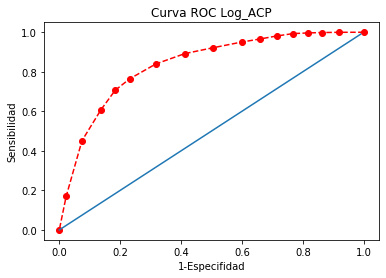

In [33]:
Yeg_pred=logiteg_model.predict(Xeg_test)
probseg=logiteg_model.predict_proba(Xeg_test)
Sensitivities_temp, Especifities_temp=ROC_analisis(probseg[:,1],Yeg_test)
Curva_ROC(Sensitivities_temp,Especifities_temp,str(Method[Method_count-1]))
Sensitivities=np.append(Sensitivities,Sensitivities_temp, axis=1)
Especifities=np.append(Especifities,Especifities_temp, axis=1)

### Matriz de confusión

In [34]:
tempdf=pd.DataFrame([conf_matrix_parameters(Yeg_pred,Yeg_test)],columns = ['TP','TN','FP','FN'])
conf_parameter = pd.concat([conf_parameter,tempdf],axis = 0)

col_0     0     1
row_0            
0      1173   400
1       825  3308


# Método SVM 

In [35]:
C_svm=160

## SVM sin ACP

In [36]:
Method.append("SVM")
Method_count+=1

In [37]:
Classifier=SVC(kernel="rbf",C=C_svm)
Classifier.fit(X_train,Y_train)
Y_pred=Classifier.predict(X_train)
Total_pred=len(Y_pred)
num_err=(Y_train==Y_pred)
Good_pred=list(num_err).count(True)
Good_pred/Total_pred

0.894922637824846

### Validación cruzada 

In [38]:
Y_pred_test=Classifier.predict(X_test)
total_pred_test=len(Y_pred_test)
num_err=(Y_test==Y_pred_test)
Good_pred=list(num_err).count(True)
Good_pred/total_pred_test

0.886435331230284

### Matriz de confusión 

In [39]:
tempdf=pd.DataFrame([conf_matrix_parameters(Y_pred_test,Y_test)],columns = ['TP','TN','FP','FN'])
conf_parameter = pd.concat([conf_parameter,tempdf],axis = 0)

col_0     0     1
row_0            
0      1509   159
1       489  3549


## SVM con ACP 

In [40]:
Method.append("SVM_ACP")
Method_count+=1

In [41]:
Classifier_eg=SVC(kernel="rbf",C=C_svm)
Classifier_eg.fit(Xeg_train,Yeg_train)
Yeg_pred=Classifier_eg.predict(Xeg_train)
Total_pred=len(Yeg_pred)
num_eg_err=(Yeg_train==Yeg_pred)
Goodeg_pred=list(num_eg_err).count(True)
Goodeg_pred/Total_pred

0.8374643232687397

### Validación cruzada

In [42]:
Yeg_pred_test=Classifier_eg.predict(Xeg_test)
total_pred_test=len(Yeg_pred_test)
num_eg_err_test=(Yeg_test==Yeg_pred_test)
Goodeg_pred=list(num_eg_err_test).count(True)
Goodeg_pred/total_pred_test

0.828776726253067

### Matriz de confusión 

In [43]:
tempdf=pd.DataFrame([conf_matrix_parameters(Yeg_pred_test,Yeg_test)],columns = ['TP','TN','FP','FN'])
conf_parameter = pd.concat([conf_parameter,tempdf],axis = 0)

col_0     0     1
row_0            
0      1249   228
1       749  3480


# Implementación modelo de k nearest

## K nearest sin acp 

In [44]:
Method.append("Kn")
Method_count+=1

In [45]:
kneig_num=5
Knear=neighbors.KNeighborsClassifier(n_neighbors=kneig_num)
Knear.fit(X_train,Y_train)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=5, p=2,
                     weights='uniform')

In [46]:
Y_pred=Knear.predict(X_train)
Total_pred=len(Y_pred)
num_err=(Y_train==Y_pred)
Good_pred=list(num_err).count(True)
Good_pred/Total_pred

0.8860597866907015

### Validación cruzada 


In [47]:
Y_pred_test=Knear.predict(X_test)
total_pred_test=len(Y_pred_test)
num_err=(Y_test==Y_pred_test)
Good_pred=list(num_err).count(True)
Good_pred/total_pred_test
Kprobs=Knear.predict_proba(X_test)
Sensitivities_temp, Especifities_temp=ROC_analisis(Kprobs[:,1],Y_test)
Sensitivities=np.append(Sensitivities,Sensitivities_temp, axis=1)
Especifities=np.append(Especifities,Especifities_temp, axis=1)

### Matriz de confusión

col_0     0     1
row_0            
0      1378   235
1       620  3473


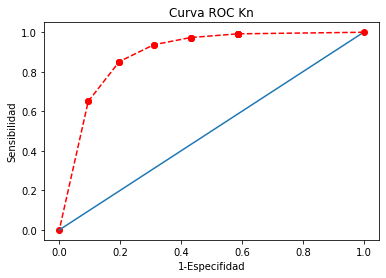

In [48]:
tempdf=pd.DataFrame([conf_matrix_parameters(Y_pred_test,Y_test)],columns = ['TP','TN','FP','FN'])
conf_parameter = pd.concat([conf_parameter,tempdf],axis = 0)
Curva_ROC(Sensitivities_temp,Especifities_temp,str(Method[Method_count-1]))

(array([ 857.,    0.,  377.,    0.,  379.,  541.,    0.,    0.,  951.,
        2601.]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <a list of 10 Patch objects>)

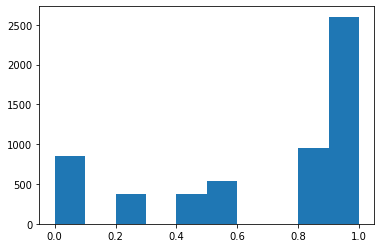

In [49]:
plt.hist(Kprobs[:,1])

## K nearest con acp 


In [50]:
Method.append("Kn_ACP")
Method_count+=1

In [51]:
Kneareg=neighbors.KNeighborsClassifier(n_neighbors=kneig_num)
Kneareg.fit(Xeg_train,Yeg_train)
Yeg_pred=Kneareg.predict(Xeg_train)
Total_pred=len(Yeg_pred)
num_err=(Yeg_train==Yeg_pred)
Good_pred=list(num_err).count(True)
Good_pred/Total_pred

0.857893946222022

### Validación cruzada 


In [52]:
Yeg_pred_test=Kneareg.predict(Xeg_test)
Kprobs_eg=Kneareg.predict_proba(Xeg_test)
Sensitivities_temp, Especifities_temp=ROC_analisis(Kprobs_eg[:,1],Yeg_test)
Sensitivities=np.append(Sensitivities,Sensitivities_temp, axis=1)
Especifities=np.append(Especifities,Especifities_temp, axis=1)
total_pred_test=len(Yeg_pred_test)
num_err=(Yeg_test==Yeg_pred_test)
Good_pred=list(num_err).count(True)
Good_pred/total_pred_test

0.8098492814581143

### Matriz de confusión

col_0     0     1
row_0            
0      1281   368
1       717  3340


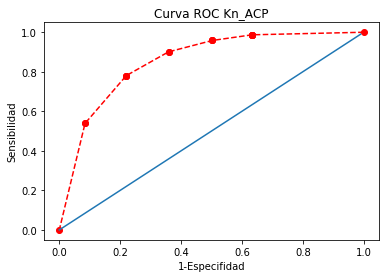

In [53]:
tempdf=pd.DataFrame([conf_matrix_parameters(Yeg_pred_test,Yeg_test)],columns = ['TP','TN','FP','FN'])
conf_parameter = pd.concat([conf_parameter,tempdf],axis = 0)
Curva_ROC(Sensitivities_temp,Especifities_temp,str(Method[Method_count-1]))

# Resultados de los modelos

In [54]:
conf_parameter["Sens"]=conf_parameter["TP"]/(conf_parameter["TP"]+conf_parameter["FN"])
conf_parameter["1-Espec"]=1-(conf_parameter["TN"]/(conf_parameter["TN"]+conf_parameter["FP"]))

conf_parameter["Prec"]=conf_parameter["TP"]/(conf_parameter["FP"]+conf_parameter["TP"])
conf_parameter["Acc"]=(conf_parameter["TP"]+conf_parameter["TN"])/(conf_parameter["FN"]+conf_parameter["FP"]+
                                                                   conf_parameter["TP"]+conf_parameter["TN"])
conf_parameter["FP_prob"]=conf_parameter["FP"]/(conf_parameter["FN"]+conf_parameter["FP"]+
                                                                   conf_parameter["TP"]+conf_parameter["TN"])

conf_parameter.index = Method
conf_parameter

,TP,TN,FP,FN,Sens,1-Espec,Prec,Acc,FP_prob
Log,3311,1213,785,397,0.892934,0.392893,0.80835,0.79285,0.137574
Log_ACP,3308,1173,825,400,0.892125,0.412913,0.800387,0.785314,0.144585
SVM,3549,1509,489,159,0.95712,0.244745,0.8789,0.886435,0.085699
SVM_ACP,3480,1249,749,228,0.938511,0.374875,0.82289,0.828777,0.131265
Kn,3473,1378,620,235,0.936624,0.31031,0.848522,0.850158,0.108658
Kn_ACP,3340,1281,717,368,0.900755,0.358859,0.823268,0.809849,0.125657


<BarContainer object of 6 artists>

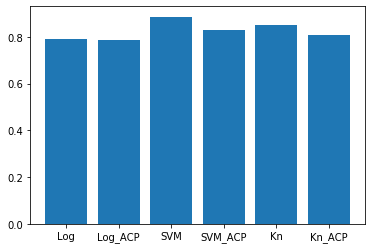

In [55]:
plt.bar(Method,conf_parameter.Acc)

* Los dos mejores modelos en cuanto a precisión son los de SVM y los de Kn. Ademas estos minimizan la probabilidad de un falso positivo (FP_prob), o cual es de gran importancia ya que es el objetivo enunciado en el dataset. 

## Comparación de curvas ROC 

Text(0.5, 1.0, 'Comparación de curvas ROC')

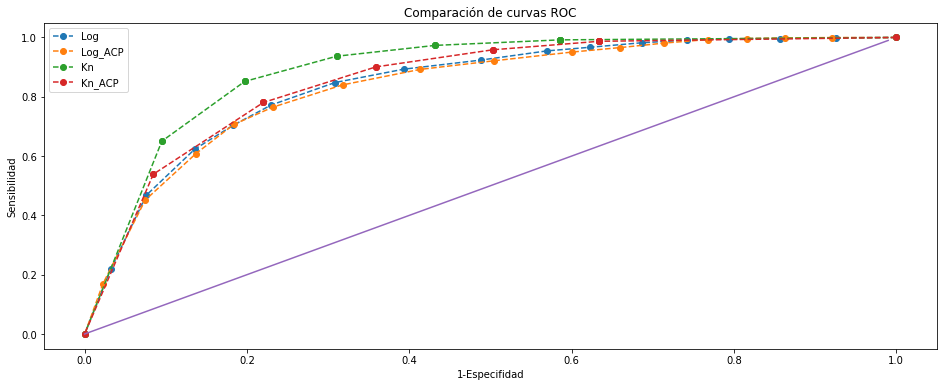

In [56]:
Method_ROC=[Method[i] for i in (0,1,4,5)]
%matplotlib inline
fig=plt.figure(figsize=(16,6))
for i in range(4):
    plt.plot(Especifities[:,i],Sensitivities[:,i],linestyle="--", marker="o")
plt.legend(Method_ROC)
x=[i*0.01 for i in range(100)]
y=[i*0.01 for i in range(100)]
plt.plot(x,y)
plt.xlabel("1-Especifidad")
plt.ylabel("Sensibilidad")
plt.title("Comparación de curvas ROC")  

* Se puede observar que el mejor modelo que puede producir una curva ROC es el de K neighbors.

* Por la necesidad de reducir la cantidad de Falsos positivos -> La especificidad debe ser máxima y 1-E menor a 0.2.   

## Ajuste de modelo kmeans a partir de curva ROC

In [57]:
trhlist=[0,0.01, 0.05,0.1,0.15,0.20,0.25, 0.3, 0.4,0.5,0.6,0.7,0.75,0.8,0.85,0.9,1]
Sensitivities_Kn, Especifities_Kn=ROC_analisis(Kprobs[:,1],Y_test)
Esp_KN_ROC=Especifities_Kn[-6]
Sens_KN_ROC=Sensitivities_Kn[-6]
list(zip(Especifities_Kn.tolist(),trhlist))

[([1.0], 0),
 ([0.5860860860860861], 0.01),
 ([0.5860860860860861], 0.05),
 ([0.5860860860860861], 0.1),
 ([0.5860860860860861], 0.15),
 ([0.5860860860860861], 0.2),
 ([0.4319319319319319], 0.25),
 ([0.4319319319319319], 0.3),
 ([0.4319319319319319], 0.4),
 ([0.3103103103103103], 0.5),
 ([0.3103103103103103], 0.6),
 ([0.1971971971971972], 0.7),
 ([0.1971971971971972], 0.75),
 ([0.1971971971971972], 0.8),
 ([0.09509509509509506], 0.85),
 ([0.09509509509509506], 0.9),
 ([0.0], 1)]

** Se selecciona un thr de 70% pues se considera un punto óptimo en cuanto a su curva ROC y permite un 1-Espec dentro de la tolerancia

In [58]:
trh=trhlist[-6]
pred_Kna_adj=np.where(Kprobs[:,1]>=trh, 1,0)
Conf_Val=[None]*9
Conf_Val[0],Conf_Val[1],Conf_Val[2],Conf_Val[3]=conf_matrix_parameters(pred_Kna_adj,Yeg_test,show_crs=False)
Conf_Val[4],Conf_Val[5],Conf_Val[6],Conf_Val[7],Conf_Val[8]=Conf_parameters(Conf_Val[0],Conf_Val[1],Conf_Val[2],Conf_Val[3])
tempdf=pd.DataFrame([Conf_Val],columns = ['TP','TN','FP','FN',"Sens","1-Espec","Prec","Acc","FP_prob"])
conf_parameter = pd.concat([conf_parameter,tempdf],axis = 0)
Method.append("Kn_70")
Method_count+=1
conf_parameter.index = Method
conf_parameter

,TP,TN,FP,FN,Sens,1-Espec,Prec,Acc,FP_prob
Log,3311,1213,785,397,0.892934,0.392893,0.80835,0.79285,0.137574
Log_ACP,3308,1173,825,400,0.892125,0.412913,0.800387,0.785314,0.144585
SVM,3549,1509,489,159,0.95712,0.244745,0.8789,0.886435,0.085699
SVM_ACP,3480,1249,749,228,0.938511,0.374875,0.82289,0.828777,0.131265
Kn,3473,1378,620,235,0.936624,0.31031,0.848522,0.850158,0.108658
Kn_ACP,3340,1281,717,368,0.900755,0.358859,0.823268,0.809849,0.125657
Kn_70,3158,1604,394,550,0.851672,0.197197,0.889077,0.83456,0.06905


# Comparación final 

In [59]:
final_df=conf_parameter.drop(["TP","TN","FP","FN"], axis=1).loc[["SVM","Kn_70"]]
final_df

,Sens,1-Espec,Prec,Acc,FP_prob
SVM,0.95712,0.244745,0.8789,0.886435,0.085699
Kn_70,0.851672,0.197197,0.889077,0.83456,0.06905


# Conclusiones

** Se consideró inicialmente que la remoción del parámetro size reduciría el error, ya que debería de ser dependiende de los parámetros Length y Width, sin embbargo esto solo se daría para elipses simétricos. Así al remover dicho parámetro, la calidad de los parámetros de comparación se había reducido considerablemente. 

** A pesar de mostrarse una aperente multicolinealidad, el uso de ACP disminuyó la calidad de los resultados los cuales mejoraban al usar todos los eigenvalores, dando los mismos resultados que sin ACP.

** Al comparar los resultados de los seis diferentes modelos usados, se determinó que los dos mejores son los de SVM y el de K neigbors, siendo el primero el de mayor  exactitud, sin embargo, debido a que el enunciado pide un valor máximo de 0.2 de 1-Espec, se elegiría el método de K neigbors. Ademas, en caso de requerir un valor máximo de 0.1, se cambia el thr por 85%.  